# TM10007 Assignment template

In [55]:
# Run this to use from colab environment
#!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [1]:
# Data loading
from worclipo.load_data import load_data

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

The number of samples: 115
The number of columns: 494


## Import packages and functions

In [2]:
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn import naive_bayes
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.preprocessing import RobustScaler, LabelEncoder
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV, ShuffleSplit, StratifiedShuffleSplit, LearningCurveDisplay
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, roc_curve, auc
from scipy.stats import randint
from scipy.interpolate import interp1d
from sklearn.tree import export_graphviz
from IPython.display import Image
#import graphviz
from sklearn.preprocessing import robust_scale
from scipy.stats import shapiro
import scipy.stats as stats
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn import svm
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import VarianceThreshold


## Description of the data 
- Checking for infinite numbers and NANs
- Checking whether the data is normally distributed
- Calculating correlation between features 
- Calculating p-values between features, to see if they significantly differ from each other

#### Checking for infinite numbers and NANs

In [3]:
# Checking for infinite numbers and NANs
def check_inf_and_nan(data, column):
    """Check if inf and nan values are present"""
    if np.isinf(data[f'{column}']).any() == True:
        return True
    if np.isnan(data[f'{column}']).any() == True:
        return True
    return False

#### Checking whether the data is normally distributed

c:\Users\michi\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


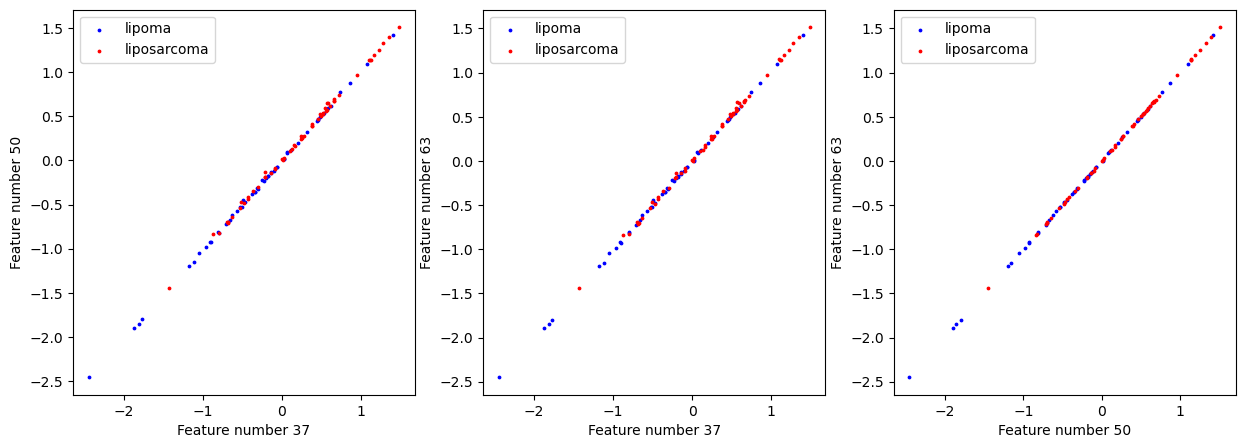

In [5]:
# Data loading
data = load_data()
X_scaled = robust_scale(data[data.columns[1:]])
data[data.columns[1:]] = X_scaled


def normal_distribution(data):
    '''
    This function checks the normal distribution of features in the dataset and performs statistical tests.
    '''
    lipoma = data[data['label'] == 'lipoma']
    liposarcoma = data[data['label'] == 'liposarcoma']

    normally_distributed_features = []  # List to store normally distributed features
    statistically_significant_features = []  # List to store statistically significant features
    statistically_significant_features_number = []  # List to store statistically significant features number

    # Loop through all features (excluding the label column)

    for feature_number, feature in enumerate(data.columns[1:], start=1):
        selected_feature_lipoma = lipoma[feature]
        selected_feature_liposarcoma = liposarcoma[feature]

        # Shapiro-Wilk test for normality
        stat_lipoma, p_lipoma = shapiro(selected_feature_lipoma)
        stat_liposarcoma, p_liposarcoma = shapiro(selected_feature_liposarcoma)

        if p_lipoma > 0.05 and p_liposarcoma > 0.05:
            # print(f"Feature '{feature}' is normally distributed")
            normally_distributed_features.append(feature)

            # Perform t-test for statistical significance
            stat, p_value = stats.ttest_ind(selected_feature_lipoma, selected_feature_liposarcoma)

            # Correct for multiple comparisons (Bonferroni correction)
            p_value *= len(normally_distributed_features)
                           
            if p_value < 0.05:
                # Save the feature number
                statistically_significant_features.append(feature)
                statistically_significant_features_number.append(feature_number)
    return lipoma, liposarcoma, normally_distributed_features, statistically_significant_features, statistically_significant_features_number

# call the function
[lipoma, liposarcoma,
 normally_distributed_features,
 statistically_significant_features,
 statistically_significant_features_number] = normal_distribution(data)

# Plot scatter of statistically significant features
fig, axis = plt.subplots(1, 3, figsize=(15, 5))

axis[0].scatter(lipoma[statistically_significant_features[0]], lipoma[statistically_significant_features[1]], color='blue', label='lipoma', s=3)
axis[0].scatter(liposarcoma[statistically_significant_features[0]], liposarcoma[statistically_significant_features[1]], color='red', label='liposarcoma', s=3)
axis[0].set_xlabel(f"Feature number {statistically_significant_features_number[0]}")
axis[0].set_ylabel(f"Feature number {statistically_significant_features_number[1]}")
axis[0].legend()

axis[1].scatter(lipoma[statistically_significant_features[0]], lipoma[statistically_significant_features[2]], color='blue', label='lipoma', s=3)
axis[1].scatter(liposarcoma[statistically_significant_features[0]], liposarcoma[statistically_significant_features[2]], color='red', label='liposarcoma', s=3)
axis[1].set_xlabel(f"Feature number {statistically_significant_features_number[0]}")
axis[1].set_ylabel(f"Feature number {statistically_significant_features_number[2]}")
axis[1].legend()

axis[2].scatter(lipoma[statistically_significant_features[1]], lipoma[statistically_significant_features[2]], color='blue', label='lipoma', s=3)
axis[2].scatter(liposarcoma[statistically_significant_features[1]], liposarcoma[statistically_significant_features[2]], color='red', label='liposarcoma', s=3)
axis[2].set_xlabel(f"Feature number {statistically_significant_features_number[1]}")
axis[2].set_ylabel(f"Feature number {statistically_significant_features_number[2]}")
axis[2].legend()

plt.show()

#### Calculating correlation between features

In [5]:
# Correlation between features
def correlation_features(data):
    '''
    This function calculates the correlation matrix between all features, seperately for the lipoma and liposarcoma groups. 
    For each feature combination (feature pair) it is determined if there is no correlation (>-0.5 and <0.5) in both groups.
    The amount of feature pairs without correlation and it's percentage is printed.
    '''
    data_lipoma = data[data['label'] == 'lipoma']
    data_lipoma.pop('label')
    corr_lipoma = data_lipoma.corr(method='pearson')
    no_corr_lipoma = (corr_lipoma>-0.5) & (corr_lipoma<0.5)
    
    data_liposarcoma = data[data['label'] == 'liposarcoma']
    data_liposarcoma.pop('label')
    corr_liposarcoma = data_liposarcoma.corr(method='pearson')
    no_corr_liposarcoma = (corr_liposarcoma>-0.5) & (corr_liposarcoma<0.5)
    
    no_corr = no_corr_lipoma & no_corr_liposarcoma
    no_corr_count = 0
    for index, Series in no_corr.iterrows():
        for counts in Series:
            if counts == True:
                no_corr_count += 1

    no_corr_amount = (no_corr_count)/2
    feature_pairs = ((len(no_corr.index)-1)*len(no_corr.index))/2
    no_corr_percentage = no_corr_amount / feature_pairs * 100
    
    print(f'The amount of feature pairs without correlation is {no_corr_amount} out of {feature_pairs} feature pairs ({no_corr_percentage:5.4}%).')

correlation_features(data)

The amount of feature pairs without correlation is 92524.0 out of 121278.0 feature pairs (76.29%).


#### Calculating p-values 

In [4]:
def calculate_p_values(data):
    """Calculates the p_values for every feature in the data between the lipoma and liposarcoma group"""
    data_lipoma = data[data['label'] == 'lipoma']
    data_liposarcoma = data[data['label'] == 'liposarcoma']
    p_values = pd.Series(0.0,index=data.columns)
    for column in data.columns:
        if any(isinstance(value, str) for value in data[f'{column}']):
            p_values = p_values.drop(f'{column}')
            continue
        stat, p = (stats.mannwhitneyu(data_lipoma[f'{column}'],data_liposarcoma[f'{column}'], axis=0))
        if p == 1.0:
            p_values = p_values.drop(f'{column}')
            continue
        p_values[f'{column}'] = p
    p_values = p_values.sort_values()
    return p_values

## Preprocessing of the data
- Anova feature selection??
- Other type of feature selection? 
- Removing features with variance = 0.0

#### Removing features with variance = 0.0

In [ ]:

# Stap 1: Filter instellen op variantie = 0 (dus constante features)
constant_filter = VarianceThreshold(threshold=0.0)

# Stap 2: Fit en transform op je featurematrix
X_filtered = constant_filter.fit_transform(X)

# Stap 3: Optioneel - kolomnamen bijwerken
filtered_feature_names = X.columns[constant_filter.get_support()]

# Eventueel X terug omzetten naar DataFrame met originele index
X_filtered_df = pd.DataFrame(X_filtered, columns=filtered_feature_names, index=X.index)

print("Origineel aantal features:", X.shape[1])
print("Aantal na verwijderen constante features:", X_filtered_df.shape[1])

NameError: name 'X' is not defined

#### ANOVA

In [8]:
from sklearn.feature_selection import SelectKBest, f_classif

# Stel: 'data' bevat zowel features als de target in één DataFrame
# Splits de features (X) en target (y)
X = X_filtered_df[:] # vervang 'target' met de echte target-kolomnaam
y = data['label']

# Pas ANOVA F-test toe om de beste features te selecteren
selector = SelectKBest(score_func=f_classif, k=20)  # choosing 20 features 
X_selected = selector.fit_transform(X, y)

# Haal de geselecteerde feature-namen op
selected_features = X.columns[selector.get_support()]
print("Geselecteerde features op basis van ANOVA:", list(selected_features))

NameError: name 'X_filtered_df' is not defined

## Classifiers 
In this section, multiple classifiers are tested and their performance is evaluated using accuracy, sensitivity, specifity and ROC curves.

To train and test these classifiers, a definition is written to split the data.

#### Split data

In [5]:
def split_data(data,split=5,n=5):
    """ Docstring for split_data"""
    train_ratio = 1/split
    split_length_max = int(np.round(train_ratio * (data.shape[0]) * n))
    features = data.drop(columns=['label'])
    label = data['label']
    split_length_min = int(np.round(train_ratio * (data.shape[0]) * (n-1)))
    features_test = features[split_length_min:split_length_max]
    features_train = features.loc[~features.index.isin(features_test.index)]
    label_test = label[split_length_min:split_length_max]
    label_train = label.loc[~label.index.isin(label_test.index)]
    return features_train,features_test,label_train,label_test

#### Linear, quadratic and logistic regression
The three models are trained with the statistically significant features. 

LET OP HIER WORDT NOG VERKEERDE TRAIN_TEST_SPLIT GEBRUIKT!!!

In [ ]:
# Select the statistically significant features
X = data[statistically_significant_features]
y = data['label'].apply(lambda x: 1 if x == 'liposarcoma' else 0)  # Convert labels to binary (0 for lipoma, 1 for liposarcoma)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize and train the logistic regression model
models = [SVC(), LinearDiscriminantAnalysis(), QuadraticDiscriminantAnalysis()]
for model_instance in models:
    # Fit the model on the training data
    model_instance.fit(X_train, y_train)
    # Make predictions on the test set
    y_pred = model_instance.predict(X_test)
    # Calculate and print the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Training model: {model_instance.__class__.__name__}, Model Accuracy: {accuracy:.4f}")

#### Naive Bayes
There are multiple ways to compute a Naive Bayes. Here, the Gaussian method is applied. The other types of Naive Bayes are not possible
- nb_bernoulli = naive_bayes.BernoulliNB() --> not possible, since the features need to be binary
- nb_complement = naive_bayes.ComplementNB() --> not possible, since the input needs to be only integers
- nb_categorical = naive_bayes.CategoricalNB() --> not possible, since the input needs to be categorical
- nb_multinomial = naive_bayes.MultinomialNB() --> not possible, since the input needs to be only integers

Naive Bayes is tested using multiple feature selection methods: 
- Based on p-values
- With Greedy forward feature selection

found a string in column "label". Did not use this column for the classifier


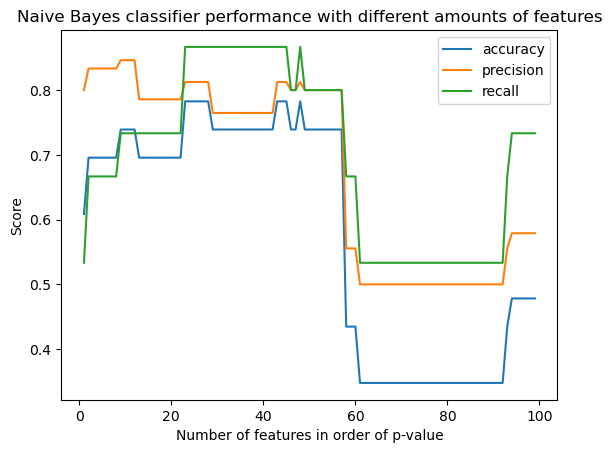

In [ ]:
# Naive Bayes classifiers based on p-values
def naive_bayes_classifier(data):
    '''
    Calculates the accuracy, precision and recall of the Gaussian Naive Bayes classifiers if the amount
    of
    '''
    p_values = calculate_p_values(data)
    features_train, features_test, label_train, label_test = split_data(data, 0.8)
    accuracy = []
    precision = []
    recall = []
    feature = []
    all_models = []

    # Performance of naive bayes classifiers for increasing amount of features in order of p-value
    for features in range(1,100):
        selected_features = p_values.index[0:features]
        features_train_selected = features_train[selected_features]
        features_test_selected = features_test[selected_features]

        nb_gaussian = naive_bayes.GaussianNB()
        nb_gaussian.fit(features_train_selected, label_train)
        all_models.append(nb_gaussian)
        label_pred = nb_gaussian.predict(features_test_selected)

        accuracy.append(accuracy_score(label_test, label_pred))
        precision.append(precision_score(label_test, label_pred, pos_label='liposarcoma'))
        recall.append(recall_score(label_test, label_pred, pos_label='liposarcoma'))
        feature.append(features)

    # Plot the results
    fig, axis = plt.subplots()
    axis.plot(feature,accuracy, label='accuracy')
    axis.plot(feature,precision, label='precision')
    axis.plot(feature,recall, label='recall')
    plt.xlabel('Number of features in order of p-value')
    plt.ylabel('Score')
    plt.title('Naive Bayes classifier performance with different amounts of features')
    plt.legend()
    plt.show()

    # Other types of naive bayes classifier are excluded:
    # nb_bernoulli = naive_bayes.BernoulliNB() --> not possible, since the features need to be binary
    # nb_complement = naive_bayes.ComplementNB() --> not possible, since the input needs to be only integers
    # nb_categorical = naive_bayes.CategoricalNB() --> not possible, since the input needs to be categorical
    # nb_multinomial = naive_bayes.MultinomialNB() --> not possible, since the input needs to be only integers

naive_bayes_classifier(data)

# Naive Bayes using Greedy forward feature selection
def perform_sfs(features_train, label_train, model, n_splits=5):
    """
    Voer Sequential Feature Selection uit voor het gekozen model.

    Parameters:
        features_train (pd.DataFrame): De training features.
        label_train (pd.Series): De training labels.
        model (sklearn model): Het model voor feature selection.
        n_splits (int): Het aantal folds voor cross-validatie.
        
    Returns:
        list: Geselecteerde features
    """
    sfs = SequentialFeatureSelector(
        model,
        n_features_to_select='auto',  # Kies automatisch het aantal features
        tol=0.01,                     # Stop als de scoreverbetering kleiner is dan 0.01
        direction='forward',
        scoring='accuracy',           # Gebruik accuracy als scoremaat
        cv=n_splits,                  # 5-fold cross-validatie
        n_jobs=-1                      # Gebruik alle cores voor parallel processing
    )
    
    # Pas SFS toe op de trainingsdata
    sfs.fit(features_train, label_train)
    
    # Geselecteerde features
    selected_features = features_train.columns[sfs.get_support()]
    
    return selected_features

# Functie om het Naive Bayes model te trainen en de accuracy te berekenen
def train_and_evaluate(features_train, features_test, label_train, label_test, selected_features):
    """
    Train het Naive Bayes model en evalueer de accuracy.

    Parameters:
        features_train (pd.DataFrame): De training features.
        features_test (pd.DataFrame): De test features.
        label_train (pd.Series): De training labels.
        label_test (pd.Series): De test labels.
        selected_features (list): De geselecteerde features uit SFS.

    Returns:
        float: De accuracy op de testdata.
    """
    # Selecteer de features die zijn gekozen door SFS
    features_train_sel = features_train[selected_features]
    features_test_sel = features_test[selected_features]
    
    # Train het Naive Bayes model
    gnb = naive_bayes.GaussianNB()
    gnb.fit(features_train_sel, label_train)
    
    # Maak voorspellingen op de testset
    y_pred = gnb.predict(features_test_sel)
    
    # Bereken de accuracy
    acc = accuracy_score(label_test, y_pred)
    
    return acc

# Functie om 5 splits uit te voeren en de accuracies te berekenen
def evaluate_model(data, n_splits=5):
    """
    Voer het model uit over 5 verschillende splits van de data en bereken de accuracies.

    Parameters:
        data (pd.DataFrame): De volledige dataset.
        n_splits (int): Het aantal splits voor cross-validation.

    Returns:
        tuple: accuracies (list), gemiddelde_accuracy (float)
    """
    accuracies = []

    for i in range(n_splits):
        print(f"Uitvoering {i + 1}:")
        
        # Split de data met een andere random seed elke keer
        features_train, features_test, label_train, label_test = split_data(data, train_ratio=0.8, random_state=i)
        
        # Voer Sequential Feature Selection uit
        selected_features = perform_sfs(features_train, label_train, GaussianNB(), n_splits=5)
        
        # Train het model en evalueer de accuracy
        acc = train_and_evaluate(features_train, features_test, label_train, label_test, selected_features)
        accuracies.append(acc)
        
        print(f"Accuracy op testset voor split {i + 1}: {acc:.4f}\n")
    
    # Gemiddelde accuracy over alle splits
    avg_accuracy = np.mean(accuracies)
    
    return accuracies, avg_accuracy

# Voer de evaluatie uit
accuracies, avg_accuracy = evaluate_model(data, n_splits=5)

# Resultaten tonen
print("Accuracies voor alle splits:")
print(accuracies)
print(f"Gemiddelde accuracy over 5 splits: {avg_accuracy:.4f}")

#### KNN classifier 
The KNN classifier is based on distance, so the data is scaled. 5 splits are performed and the optimal k is determined using 5-fold cross validation. ROC curves are made for each split to visualize the True Positive Rate and the False Positive Rate

Best number of components selected: 1

Processing Split 1
Optimal k: 7
Test Accuracy: 0.5217
Test AUC: 0.5500

Processing Split 2
Optimal k: 19
Test Accuracy: 0.6957
Test AUC: 0.7769

Processing Split 3
Optimal k: 7
Test Accuracy: 0.5652
Test AUC: 0.6577

Processing Split 4
Optimal k: 7
Test Accuracy: 0.6087
Test AUC: 0.6731

Processing Split 5
Optimal k: 19
Test Accuracy: 0.4783
Test AUC: 0.5198


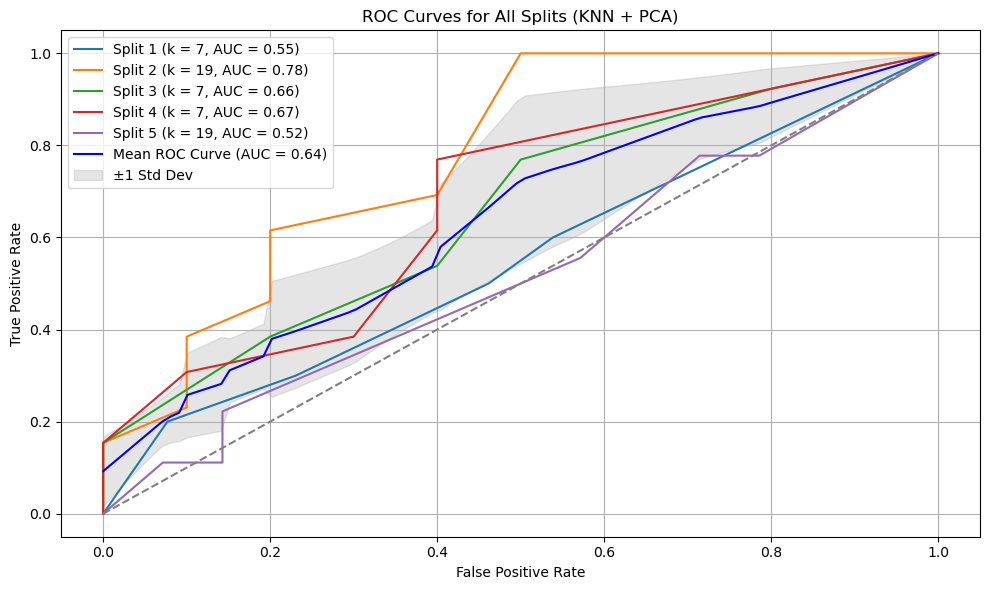

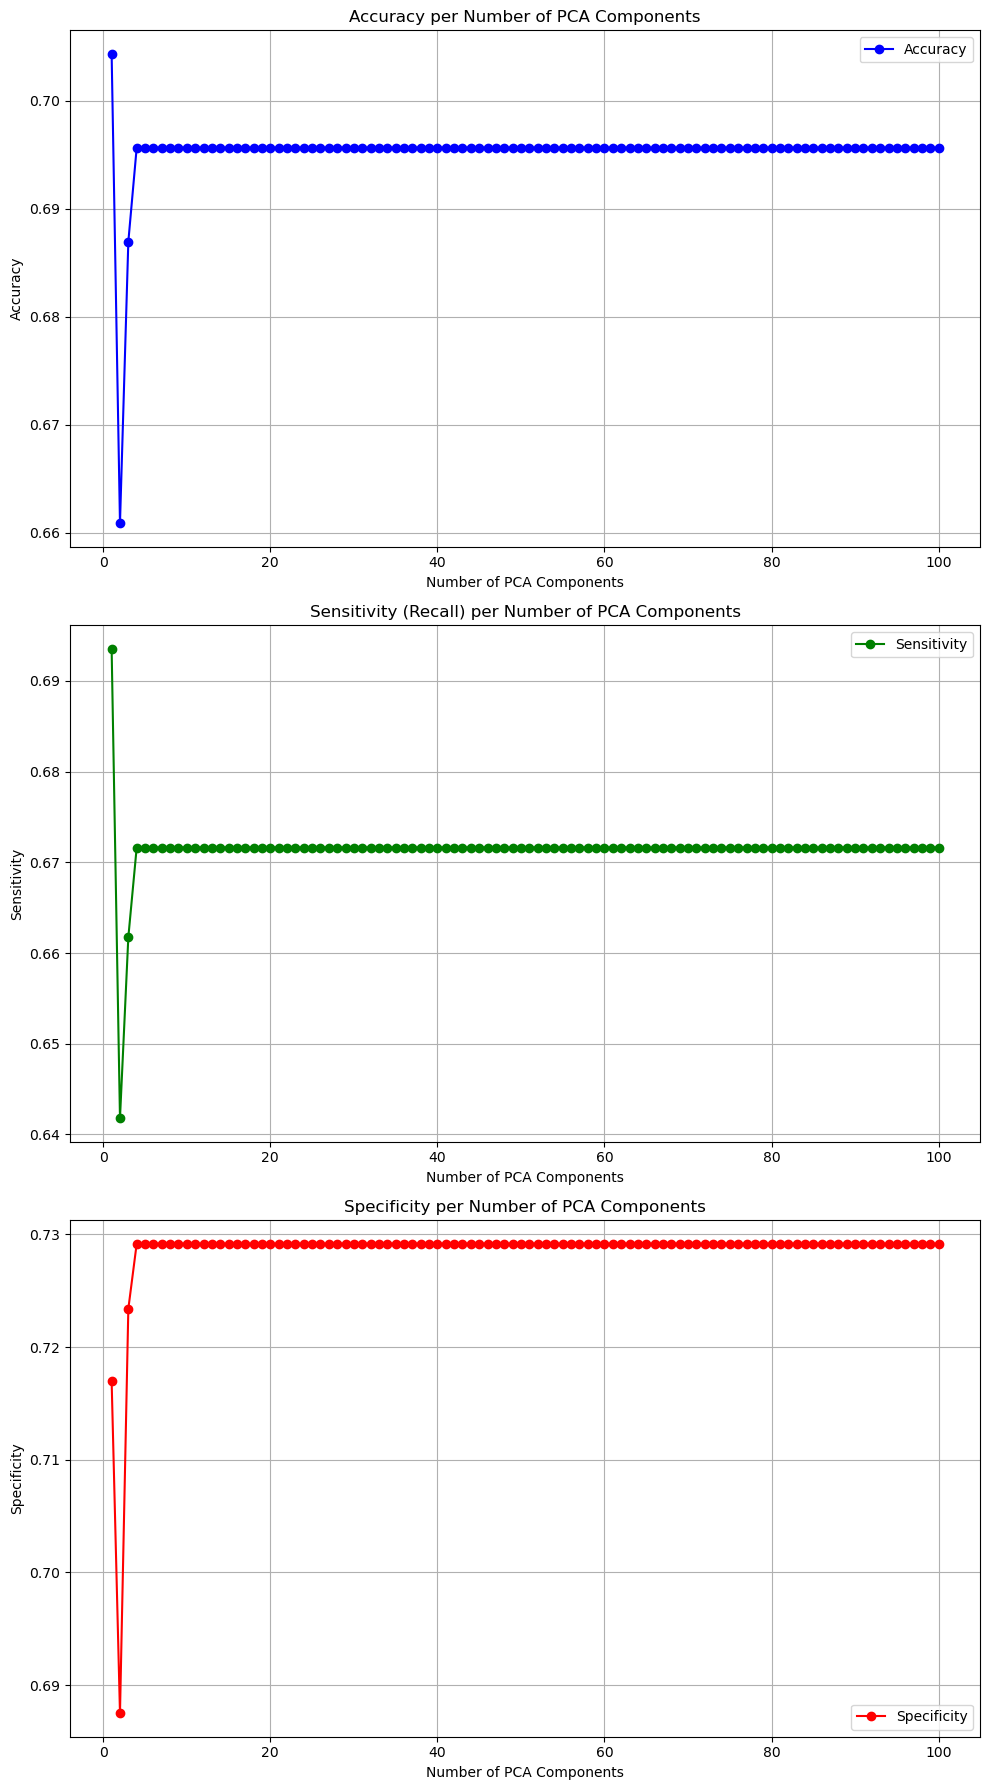

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

# Split data function
def split_data(data, split=5, n=5):
    """ Custom splitting function for data."""
    train_ratio = 1 / split
    split_length_max = int(np.round(train_ratio * (data.shape[0]) * n))
    features = data.drop(columns=['label'])
    label = data['label']
    split_length_min = int(np.round(train_ratio * (data.shape[0]) * (n-1)))
    features_test = features[split_length_min:split_length_max]
    features_train = features.loc[~features.index.isin(features_test.index)]
    label_test = label[split_length_min:split_length_max]
    label_train = label.loc[~label.index.isin(label_test.index)]
    return features_train, features_test, label_train, label_test


def pca_feature_selection(features_train, features_test, label_train, label_test, model_test, max_components=100):
    accuracy = []
    precision = []
    recall = []
    added_scores = []

    # PCA only on the training set
    for components in range(1, max_components + 1):
        pca = PCA(n_components=components)
        pca_transform_train = pca.fit_transform(features_train)
        data_pca_train = pd.DataFrame(data=pca_transform_train, columns=[f'PC{i+1}' for i in range(components)])

        # Transform the test set with the same PCA
        pca_transform_test = pca.transform(features_test)
        data_pca_test = pd.DataFrame(data=pca_transform_test, columns=[f'PC{i+1}' for i in range(components)])

        data_pca_train['label'] = label_train.values
        data_pca_test['label'] = label_test.values

        # Train model and make predictions
        model_test.fit(data_pca_train.drop(columns='label'), data_pca_train['label'])
        label_pred = model_test.predict(data_pca_test.drop(columns='label'))

        acc = accuracy_score(data_pca_test['label'], label_pred)
        sen = precision_score(data_pca_test['label'], label_pred, pos_label='liposarcoma')
        spe = precision_score(data_pca_test['label'], label_pred, pos_label='lipoma')

        accuracy.append(acc)
        precision.append(sen)
        recall.append(spe)
        added_scores.append(acc + sen + spe)

    best_index = np.argmax(added_scores)
    best_n_components = best_index + 1  # will start the range at 1

    return best_n_components, accuracy, precision, recall

def cross_validate_knn_with_pca(n_components, k_values=[1, 3, 5, 7, 9, 11, 13, 15, 17, 19], random_state=42, n_splits=5):
    np.random.seed(random_state)
    roc_data_all_splits = []

    # Loop through the 5 splits of KFold
    for split_index in range(1, n_splits + 1):
        print(f"\nProcessing Split {split_index}")

        # Get the correct split using the split_data function
        features_train, features_test, label_train, label_test = split_data(data, split=n_splits, n=split_index)  # pass the entire data

        # Encode labels
        encoder = LabelEncoder()
        label_train_encoded = encoder.fit_transform(label_train)
        label_test_encoded = encoder.transform(label_test)

        # Scale the training data and apply the same scaling transformation to the test data
        scaler = RobustScaler()
        features_train_scaled = scaler.fit_transform(features_train)  # Fit the scaler only on the training data
        features_test_scaled = scaler.transform(features_test)  # Use the same scaler for the test data

        # PCA fit on the scaled training set, transform both
        pca = PCA(n_components=n_components)
        features_train_pca = pca.fit_transform(features_train_scaled)
        features_test_pca = pca.transform(features_test_scaled)

        # Cross-validate to find the best k on the training set
        cv_scores = []
        for k in k_values:
            knn = KNeighborsClassifier(n_neighbors=k)
            scores = cross_val_score(knn, features_train_pca, label_train_encoded, cv=5, scoring='accuracy')
            cv_scores.append(scores.mean())

        optimal_k = k_values[np.argmax(cv_scores)]
        print(f"Optimal k: {optimal_k}")

        # Train final model on the training data
        knn_final = KNeighborsClassifier(n_neighbors=optimal_k)
        knn_final.fit(features_train_pca, label_train_encoded)

        # Evaluate on the test set
        test_pred = knn_final.predict(features_test_pca)
        acc = accuracy_score(label_test_encoded, test_pred)
        print(f"Test Accuracy: {acc:.4f}")

        y_pred_prob = knn_final.predict_proba(features_test_pca)[:, 1]
        fpr, tpr, _ = roc_curve(label_test_encoded, y_pred_prob)
        roc_auc = auc(fpr, tpr)
        print(f"Test AUC: {roc_auc:.4f}")

        # Append the k value and ROC data for later use in plotting
        roc_data_all_splits.append((fpr, tpr, roc_auc, optimal_k))

    return roc_data_all_splits

def plot_roc_curves(roc_data_all_splits):
    plt.figure(figsize=(10, 6))

    # Initialize variables to compute the mean and standard deviation
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.zeros_like(mean_fpr)
    std_tpr = np.zeros_like(mean_fpr)

    # Plot each split's ROC curve with the corresponding k value
    for split_index, (fpr, tpr, roc_auc, optimal_k) in enumerate(roc_data_all_splits):
        label = f'Split {split_index + 1} (k = {optimal_k}, AUC = {roc_auc:.2f})'
        plt.plot(fpr, tpr, label=label)

        # Interpolate the true positive rate to get a consistent number of points
        mean_tpr += np.interp(mean_fpr, fpr, tpr)

    # Compute the average true positive rate and the standard deviation
    mean_tpr /= len(roc_data_all_splits)

    # Compute the standard deviation of the true positive rate
    for fpr, tpr, _, _ in roc_data_all_splits:
        std_tpr += (np.interp(mean_fpr, fpr, tpr) - mean_tpr) ** 2

    std_tpr = np.sqrt(std_tpr / len(roc_data_all_splits))

    # Plot the mean ROC curve
    plt.plot(mean_fpr, mean_tpr, color='b', label='Mean ROC Curve (AUC = {:.2f})'.format(auc(mean_fpr, mean_tpr)))

    # Plot the shaded area for the standard deviation
    plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='gray', alpha=0.2, label='±1 Std Dev')

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.title('ROC Curves for All Splits (KNN + PCA)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_pca_performance(accuracy, precision, recall, max_components=100):
    # Create a figure with 3 subplots for the different metrics
    fig, axes = plt.subplots(3, 1, figsize=(10, 18))

    # Plot the accuracy per number of components
    axes[0].plot(range(1, max_components + 1), accuracy, marker='o', linestyle='-', color='b', label='Accuracy')
    axes[0].set_title('Accuracy per Number of PCA Components')
    axes[0].set_xlabel('Number of PCA Components')
    axes[0].set_ylabel('Accuracy')
    axes[0].grid(True)
    axes[0].legend()

    # Plot the sensitivity per number of components
    axes[1].plot(range(1, max_components + 1), precision, marker='o', linestyle='-', color='g', label='Sensitivity')
    axes[1].set_title('Sensitivity (Recall) per Number of PCA Components')
    axes[1].set_xlabel('Number of PCA Components')
    axes[1].set_ylabel('Sensitivity')
    axes[1].grid(True)
    axes[1].legend()

    # Plot the specificity per number of components
    axes[2].plot(range(1, max_components + 1), recall, marker='o', linestyle='-', color='r', label='Specificity')
    axes[2].set_title('Specificity per Number of PCA Components')
    axes[2].set_xlabel('Number of PCA Components')
    axes[2].set_ylabel('Specificity')
    axes[2].grid(True)
    axes[2].legend()

    plt.tight_layout()
    plt.show()

# Main Program
# Assuming `data` is your DataFrame
features = data.drop(columns='label')
labels = data['label']

# Perform PCA feature selection on the training data
best_n_components, accuracy, precision, recall = pca_feature_selection(features, features, labels, labels, model_test=KNeighborsClassifier(), max_components=100)

# Print the best number of components
print(f"Best number of components selected: {best_n_components}")

# Perform KNN cross-validation with PCA on the selected components
roc_data_all_splits = cross_validate_knn_with_pca(n_components=best_n_components, random_state=42, n_splits=5)

# Plot ROC curves
plot_roc_curves(roc_data_all_splits)

# Optionally, plot PCA performance
plot_pca_performance(accuracy, precision, recall, max_components=100)


#### Random Forest

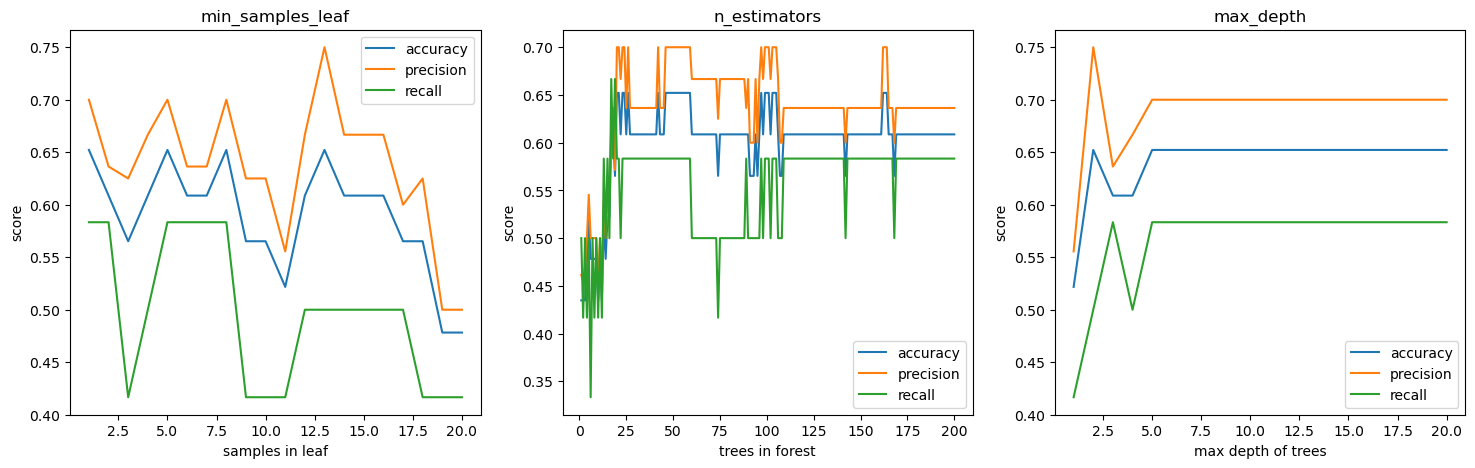

In [6]:
def test_hyperparameter(parameter,value_max):
    accuracy = []
    precision = []
    recall = []
    values = []
    for value in range(1,(value_max+1)):
        model_test = RandomForestClassifier(**{parameter: value}, random_state=42)
        model_test.fit(features_train, label_train)
        label_pred = model_test.predict(features_test)
        accuracy.append(accuracy_score(label_test, label_pred))
        precision.append(precision_score(label_test, label_pred, pos_label='liposarcoma'))
        recall.append(recall_score(label_test, label_pred, pos_label='liposarcoma'))
        values.append(value)
    return accuracy,precision,recall,values

def plot_testing_values(axis, title,xlabel,ylabel,values,accuracy,precision,recall):
    axis.plot(values,accuracy, label='accuracy')
    axis.plot(values,precision, label='precision')
    axis.plot(values,recall, label='recall')
    axis.set_xlabel(xlabel)
    axis.set_ylabel(ylabel)
    axis.set_title(title)
    axis.legend()

data_lipoma = data[data['label'] == 'lipoma']
data_liposarcoma = data[data['label'] == 'liposarcoma']

split_lipoma = split_data(data_lipoma)
split_liposarcoma = split_data(data_liposarcoma)
features_train, features_test, label_train, label_test = [
    pd.concat([x, y]) for x, y in zip(split_lipoma, split_liposarcoma)
    ]

fig, axis = plt.subplots(1,3, figsize=(18,5))
accuracy1, precision1, recall1, values1 = test_hyperparameter('min_samples_leaf', 20)
plot_testing_values(axis[0], 'min_samples_leaf','samples in leaf','score', values1, accuracy1, precision1, recall1)
accuracy2, precision2, recall2, values2 = test_hyperparameter('n_estimators', 200)
plot_testing_values(axis[1], 'n_estimators','trees in forest','score', values2, accuracy2, precision2, recall2)
accuracy3, precision3, recall3, values3 = test_hyperparameter('max_depth', 20)
plot_testing_values(axis[2], 'max_depth','max depth of trees','score', values3, accuracy3, precision3, recall3)

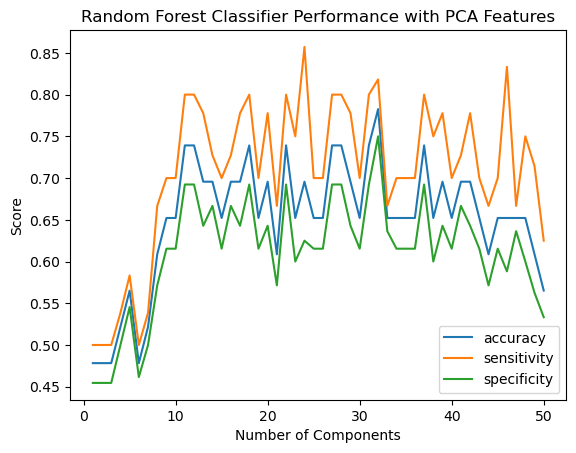

In [15]:
def pca_feature_selection(data, model_test):
    accuracy = []
    precision = []
    recall = []
    added_scores = []
    for components in range(1, 51, 1):
        pca = PCA(n_components=components)
        pca_transform = pca.fit_transform(data.drop(columns='label'))
        data_pca = pd.DataFrame(data=pca_transform, columns=[f'PC{i+1}' for i in range(pca_transform.shape[1])])
        data_pca['label'] = data['label'].values

        data_lipoma_pca = data_pca[data_pca['label'] == 'lipoma']
        data_liposarcoma_pca = data_pca[data_pca['label'] == 'liposarcoma']

        split_lipoma_pca = split_data(data_lipoma_pca)
        split_liposarcoma_pca = split_data(data_liposarcoma_pca)
        features_train, features_test, label_train, label_test = [
        pd.concat([x, y]) for x, y in zip(split_lipoma_pca, split_liposarcoma_pca)
        ]

        model_test.fit(features_train, label_train)
        label_pred = model_test.predict(features_test)
        acc = accuracy_score(label_test, label_pred)
        sen = precision_score(label_test, label_pred, pos_label='liposarcoma')
        spe = precision_score(label_test, label_pred, pos_label='lipoma')
        accuracy.append(acc)
        precision.append(sen)
        recall.append(spe)
        added_scores.append(acc+sen+spe)
    return added_scores, accuracy, precision, recall

# Plot components vs accuracy, precision and recall in 1 figure
model = RandomForestClassifier(min_samples_leaf=5, random_state=42, n_estimators=100, max_depth=10)
add_scores, accuracy, precision, recall = pca_feature_selection(data, model)
fig, axis = plt.subplots()
axis.plot(range(1, 51, 1), accuracy, label='accuracy')
axis.plot(range(1, 51, 1), precision, label='sensitivity')
axis.plot(range(1, 51, 1), recall, label='specificity')
plt.xlabel('Number of Components')
plt.ylabel('Score')
plt.title('Random Forest Classifier Performance with PCA Features')
plt.legend()
plt.show()

In [16]:
import warnings

warnings.filterwarnings("ignore", message=".*DataFrame is highly fragmented.*")
def forward_filtering(data, model):
    # forward selection method
    # sort the features by p-value
    p_values = calculate_p_values(data)

    data_p_values = pd.DataFrame(p_values, columns=['p_value'])
    data_p_values['feature'] = data_p_values.index
    data_p_values = data_p_values.reset_index(drop=True)

    # Make a loop adding features one by one and check the accuracy of the model
    features = []

    accuracies = []
    specificities = []
    sensitivities = []
    added_scores = []
    # Loop through features
    for feature in range(0, 150):
        features.append(data_p_values['feature'][feature])
        features_train, features_test, label_train, label_test = train_test_split(data[features], data['label'], test_size=0.2, random_state=41, stratify=data['label'])
        # Store accuracy scores for the current feature
        param_dist = {'n_estimators': randint(1,150),
            'max_depth': randint(2,10),
            'min_samples_leaf': randint(3,10)}

        model.fit(features_train, label_train)
        label_pred = model.predict(features_test)
        acc = accuracy_score(label_test, label_pred)
        sen = precision_score(label_test, label_pred, pos_label='liposarcoma')
        spe = precision_score(label_test, label_pred, pos_label='lipoma')
        accuracies.append(acc)
        specificities.append(spe)
        sensitivities.append(sen)
        added_scores.append(acc+sen+spe)
    return accuracies, specificities, sensitivities, added_scores

Text(0.5, 1.0, 'Sensitivity')

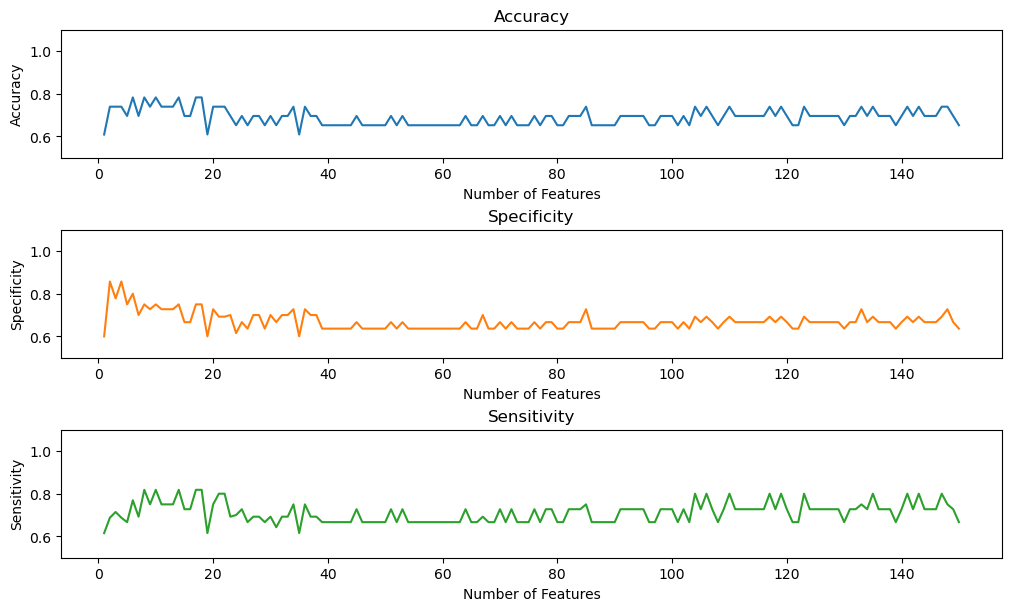

In [17]:
model = RandomForestClassifier(min_samples_leaf=5, max_depth=10, n_estimators=75, random_state=42)
accuracy_df, specificity_df, sensitivity_df, added_scores= forward_filtering(data, model)
fig, axis = plt.subplots(3, figsize=(10,6), constrained_layout=True)
axis[0].plot(range(1, len(accuracy_df)+1), accuracy_df, label='accuracy', color='tab:blue')
axis[0].set_xlabel('Number of Features')
axis[0].set_ylabel('Accuracy')
axis[0].set_ylim(0.5, 1.1)
axis[0].set_title('Accuracy')

axis[1].plot(range(1, len(specificity_df)+1), specificity_df, label='specificity', color='tab:orange')
axis[1].set_xlabel('Number of Features')
axis[1].set_ylabel('Specificity')
axis[1].set_ylim(0.5, 1.1)
axis[1].set_title('Specificity')

axis[2].plot(range(1, len(sensitivity_df)+1), sensitivity_df, label='sensitivity', color='tab:green')
axis[2].set_xlabel('Number of Features')
axis[2].set_ylabel('Sensitivity')
axis[2].set_ylim(0.5, 1.1)
axis[2].set_title('Sensitivity')

In [28]:
def learning_curve_plot(model, best_hyper_params, data_used):
    if model == SVC:
        model = model(random_state=42, **best_hyper_params, kernel='rbf')
    else:
        model = model(random_state=42, **best_hyper_params)
    fig, ax = plt.subplots(figsize=(10, 6), sharey=True)
    common_params = {
        "X": data_used.drop(columns='label'),
        "y": data_used['label'],
        "train_sizes": np.linspace(0.1, 1.0, 20),
        "cv": ShuffleSplit(n_splits=20, test_size=0.2, random_state=0),
        "score_type": "both",
        "n_jobs": 4,
        "line_kw": {"marker": "o"},
        "std_display_style": "fill_between",
        "score_name": "Accuracy",
    }
    LearningCurveDisplay.from_estimator(model, **common_params, ax=ax)
    handles, label = ax.get_legend_handles_labels()
    ax.legend(handles[:2], ["Training Score", "Test Score"])
    ax.set_title(f"Learning Curve for {model.__class__.__name__}")

Best hyperparameters: {'max_depth': 8, 'min_samples_leaf': 7, 'n_estimators': 72}
Accuracy: 0.8695652173913043, Specificity: 0.9090909090909091, Sensitivity: 0.8333333333333334
Best hyperparameters: {'max_depth': 8, 'min_samples_leaf': 7, 'n_estimators': 72}
Accuracy: 0.7391304347826086, Specificity: 0.5833333333333334, Sensitivity: 0.9090909090909091
Best hyperparameters: {'max_depth': 8, 'min_samples_leaf': 7, 'n_estimators': 72}
Accuracy: 0.7391304347826086, Specificity: 0.7272727272727273, Sensitivity: 0.75
Best hyperparameters: {'max_depth': 3, 'min_samples_leaf': 7, 'n_estimators': 75}
Accuracy: 0.782608695652174, Specificity: 0.8333333333333334, Sensitivity: 0.7272727272727273
Best hyperparameters: {'max_depth': 3, 'min_samples_leaf': 7, 'n_estimators': 75}
Accuracy: 0.6086956521739131, Specificity: 0.7272727272727273, Sensitivity: 0.5
Best hyperparameters: {'max_depth': 6, 'min_samples_leaf': 9, 'n_estimators': 103}
Accuracy: 0.4782608695652174, Specificity: 0.45454545454545453

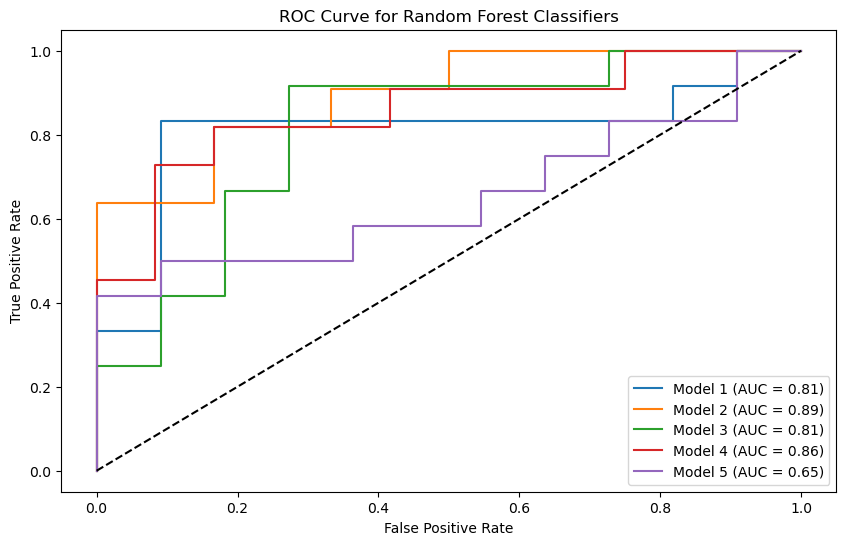

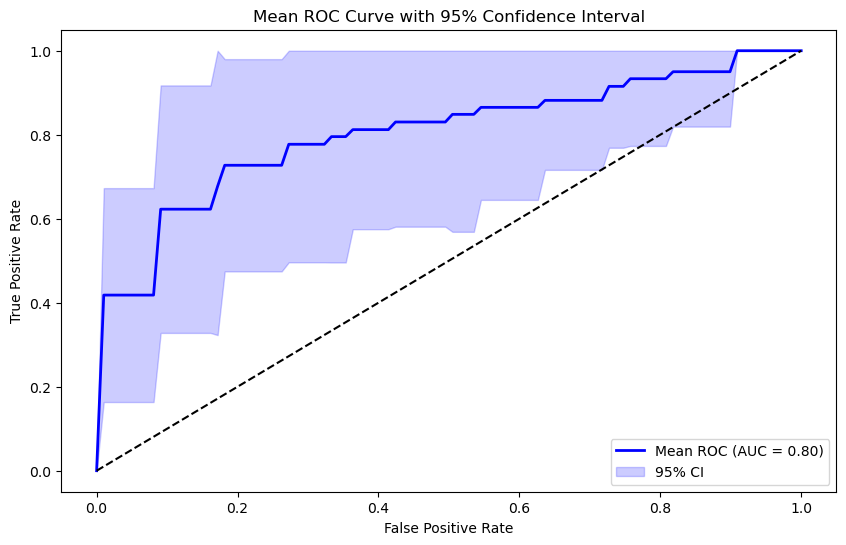

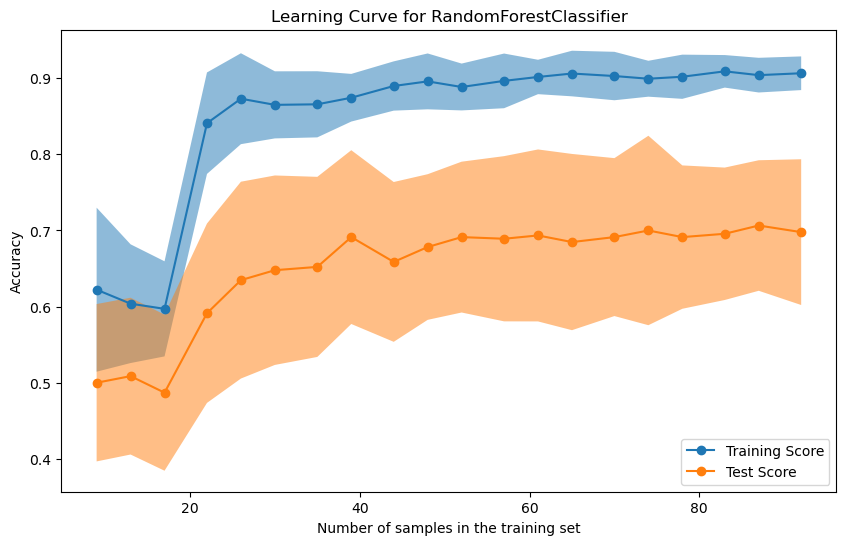

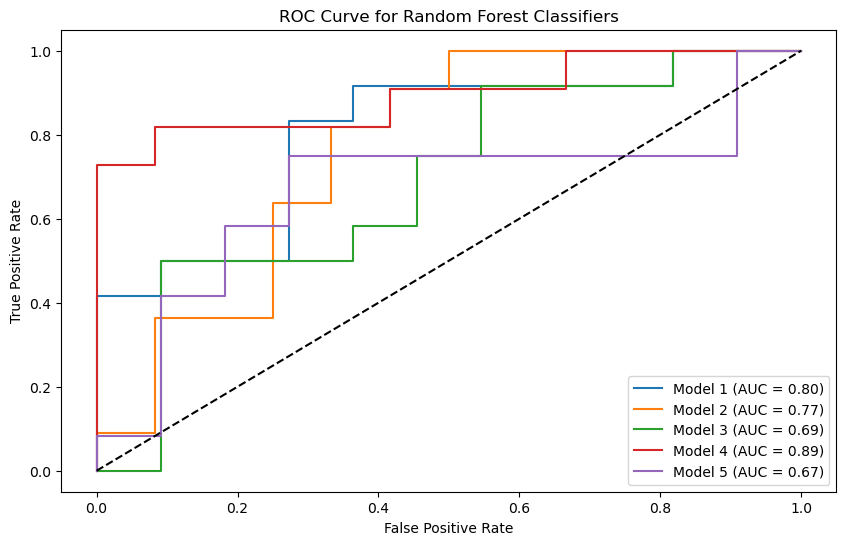

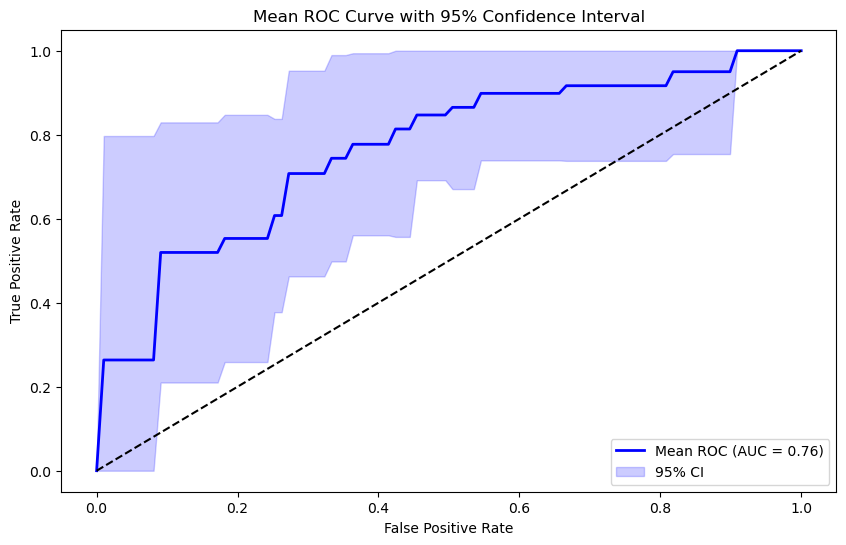

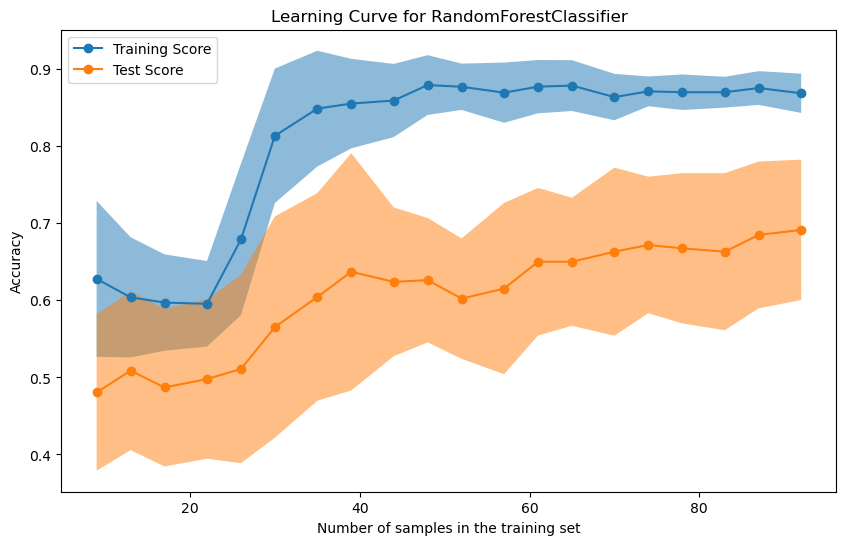

In [ ]:
def random_forest_classifier(data, selection):
    param_dist = {'n_estimators': randint(1,150),
                  'max_depth': randint(2,10),
                  'min_samples_leaf': randint(5,10)}

    model = RandomForestClassifier(random_state=42)

    rand_search = RandomizedSearchCV(model, 
                                     param_distributions = param_dist, 
                                     n_iter=5, 
                                     cv=5,
                                     random_state=42)

    n = 5
    accuracy = []
    specificity = []
    sensitivity = []
    all_roc = np.linspace(0, 1, 100)
    roc_list = []
    best_rf_complete = []
    best_hyper_params = []
    features = []
    plt.figure(figsize=(10, 6))
    for i in range(1,n+1):
        if selection == 'forward filtering':
            split_lipoma = split_data(data_lipoma, n, i)
            split_liposarcoma = split_data(data_liposarcoma, n, i)
            features_train, features_test, label_train, label_test = [
                pd.concat([x, y]) for x, y in zip(split_lipoma, split_liposarcoma)
                ]
            train_data_rf = pd.concat([features_train, label_train], axis=1)
            model_select = RandomForestClassifier(min_samples_leaf=5, max_depth=10, n_estimators=75, random_state=42)
            accuracies, specificies, sensitivities, added_scores = forward_filtering(train_data_rf, model_select)
            best_features = added_scores.index(max(added_scores))+1
            features.append(best_features)
            p_values = calculate_p_values(train_data_rf)
            p_values_used = p_values[:best_features].index
            columns_to_keep = list(p_values_used)
            features_train = features_train[columns_to_keep]
            features_test = features_test[columns_to_keep]
        elif selection == 'pca':
            model_test = RandomForestClassifier(min_samples_leaf=5, random_state=42, n_estimators=100, max_depth=10)
            add_scores, accuracy, sensitivity, specificity = pca_feature_selection(data, model_test)
            best_pca = add_scores.index(max(add_scores))+1
            features.append(best_pca)
            pca = PCA(n_components=best_pca)
            pca_transform = pca.fit_transform(data.drop(columns='label'))
            data_pca = pd.DataFrame(data=pca_transform, columns=[f'PC{i+1}' for i in range(pca_transform.shape[1])])
            data_pca['label'] = data['label'].values

            data_lipoma_pca = data_pca[data_pca['label'] == 'lipoma']
            data_liposarcoma_pca = data_pca[data_pca['label'] == 'liposarcoma']

            split_lipoma_pca = split_data(data_lipoma_pca, n, i)
            split_liposarcoma_pca = split_data(data_liposarcoma_pca, n, i)
            features_train, features_test, label_train, label_test = [
            pd.concat([x, y]) for x, y in zip(split_lipoma_pca, split_liposarcoma_pca)
            ]

        rand_search.fit(features_train, label_train)
        best_rf = rand_search.best_estimator_
        best_rf_complete.append(best_rf)
        best_hyper_params.append(rand_search.best_params_)
        print('Best hyperparameters:',  rand_search.best_params_)

        label_pred = best_rf.predict(features_test)
        label_prob = best_rf.predict_proba(features_test)[:, 1]

        accuracy.append(accuracy_score(label_test, label_pred))
        specificity.append(recall_score(label_test, label_pred, pos_label='lipoma'))
        sensitivity.append(recall_score(label_test, label_pred, pos_label='liposarcoma'))
        print(f'Accuracy: {accuracy[i-1]}, Specificity: {specificity[i-1]}, Sensitivity: {sensitivity[i-1]}')

        fpr, tpr, _ = roc_curve(label_test, label_prob, pos_label='liposarcoma')
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, label=f'Model {i} (AUC = {roc_auc:.2f})')

        interp_roc = interp1d(fpr, tpr, kind='linear', bounds_error=False, fill_value=0)(all_roc)
        interp_roc[0] = 0
        roc_list.append(interp_roc)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Random Forest Classifiers')
    plt.legend(loc='lower right')

    roc_array = np.array(roc_list)
    mean_roc = np.mean(roc_array, axis=0)
    std_roc = np.std(roc_array, axis=0)
    ci_upper = np.minimum(mean_roc + 1.96 * std_roc, 1)
    ci_lower = np.maximum(mean_roc - 1.96 * std_roc, 0)
    mean_auc = auc(all_roc, mean_roc)

    plt.figure(figsize=(10, 6))
    plt.plot(all_roc, mean_roc, color='blue', label=f'Mean ROC (AUC = {mean_auc:.2f})', linewidth=2)
    plt.fill_between(all_roc, ci_lower, ci_upper, color='blue', alpha=0.2, label='95% CI')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Mean ROC Curve with 95% Confidence Interval')
    plt.legend(loc='lower right')
    return best_rf_complete, best_hyper_params, features

# for i in range(1):
#     tree = best_rf.estimators_[i]
#     dot_data = export_graphviz(tree,
#                                feature_names=features_train.columns,  
#                                filled=True,  
#                                max_depth=3, 
#                                impurity=True, 
#                                proportion=False)
#     graph = graphviz.Source(dot_data)
#     display(graph)

best_rf_complete, best_hyper_params, feature_amount = random_forest_classifier(data, 'forward filtering')

p_values = calculate_p_values(data)
p_values_used = p_values[:feature_amount[0]].index
columns_to_keep = list(p_values_used) + ['label']
data_used = data[columns_to_keep]
learning_curve_plot(RandomForestClassifier, best_hyper_params[0], data_used)

best_rf_complete, best_hyper_params, pca_comp = random_forest_classifier(data, 'pca')

pca = PCA(n_components=pca_comp[0])
pca_transform = pca.fit_transform(data.drop(columns='label'))
data_pca = pd.DataFrame(data=pca_transform, columns=[f'PC{i+1}' for i in range(pca_transform.shape[1])])
data_pca['label'] = data['label'].values
learning_curve_plot(RandomForestClassifier, best_hyper_params[0], data_pca)

--------------------------------------

#### Support Vector Machine


In [22]:
split_lipoma = split_data(data_lipoma)
split_liposarcoma = split_data(data_liposarcoma)
features_train, features_test, label_train, label_test = [
    pd.concat([x, y]) for x, y in zip(split_lipoma, split_liposarcoma)
    ]
train_data_svm = pd.concat([features_train, label_train], axis=1)
p_values = calculate_p_values(train_data_svm)
p_values_used = p_values[:20].index
columns_to_keep = list(p_values_used)
features_train = features_train[columns_to_keep]
features_test = features_test[columns_to_keep]

# Train different SVM models with different kernels
kernels = ['poly', 'rbf', 'sigmoid']
for kernel in kernels:
    model = SVC(kernel=kernel, random_state=42)
    model.fit(features_train, label_train)
    y_pred = model.predict(features_test)
    accuracy = accuracy_score(label_test, y_pred)
    print(f"Training model: {model.__class__.__name__}, Kernel: {kernel}, Model Accuracy: {accuracy:.4f}")

Training model: SVC, Kernel: poly, Model Accuracy: 0.5217
Training model: SVC, Kernel: rbf, Model Accuracy: 0.5217
Training model: SVC, Kernel: sigmoid, Model Accuracy: 0.4348


Best hyperparameters: {'C': 5.623413251903491, 'gamma': 1e-07}
Accuracy: 0.6521739130434783, Specificity: 0.5454545454545454, Sensitivity: 0.75
Best hyperparameters: {'C': 21.544346900318846, 'gamma': 1e-07}
Accuracy: 0.4782608695652174, Specificity: 0.25, Sensitivity: 0.7272727272727273
Best hyperparameters: {'C': 5.623413251903491, 'gamma': 1e-07}
Accuracy: 0.782608695652174, Specificity: 0.6363636363636364, Sensitivity: 0.9166666666666666
Best hyperparameters: {'C': 21.544346900318846, 'gamma': 1e-07}
Accuracy: 0.6086956521739131, Specificity: 0.4166666666666667, Sensitivity: 0.8181818181818182
Best hyperparameters: {'C': 21.544346900318846, 'gamma': 1e-07}
Accuracy: 0.6956521739130435, Specificity: 0.6363636363636364, Sensitivity: 0.75
Best hyperparameters: {'C': 0.1, 'gamma': 1e-07}
Accuracy: 0.4782608695652174, Specificity: 0.0, Sensitivity: 0.5
Best hyperparameters: {'C': 0.1, 'gamma': 1e-07}
Accuracy: 0.4782608695652174, Specificity: 0.0, Sensitivity: 0.5
Best hyperparameters: 

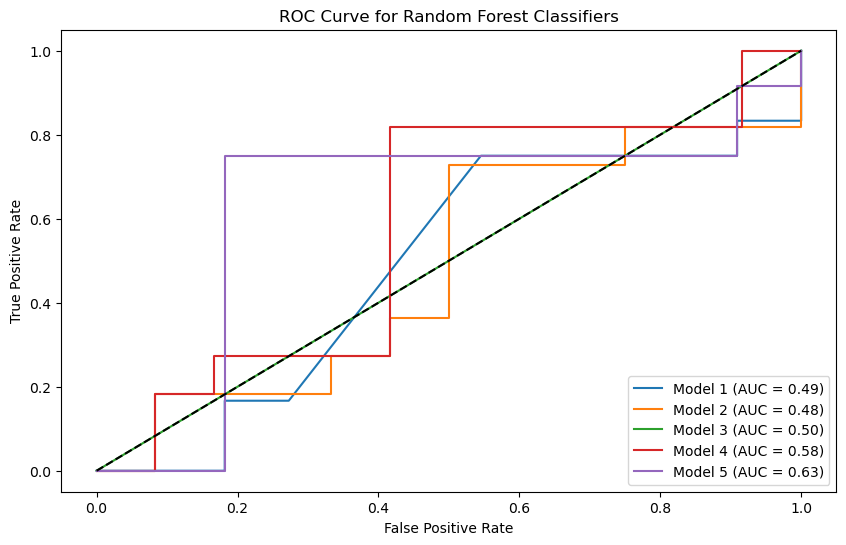

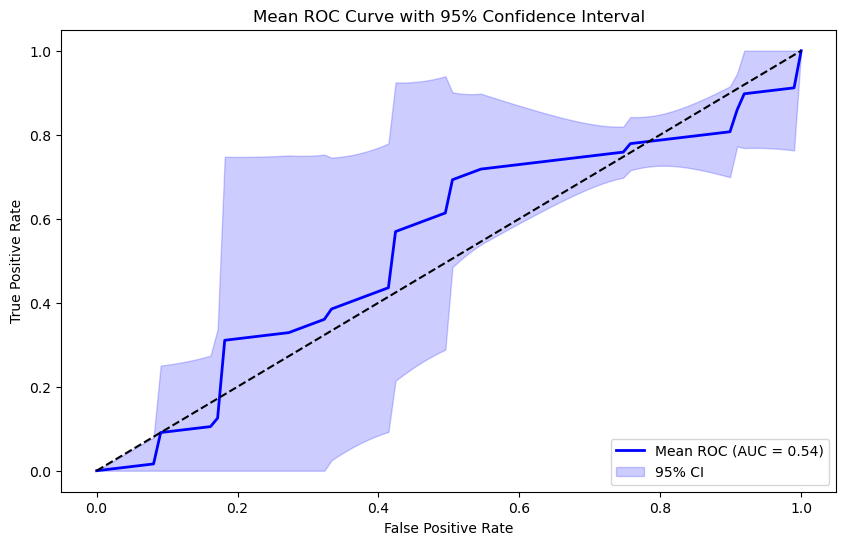

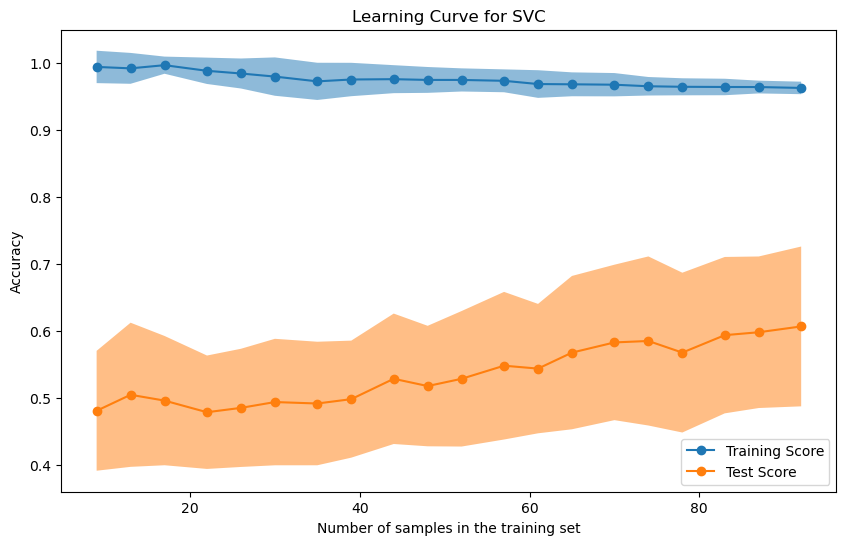

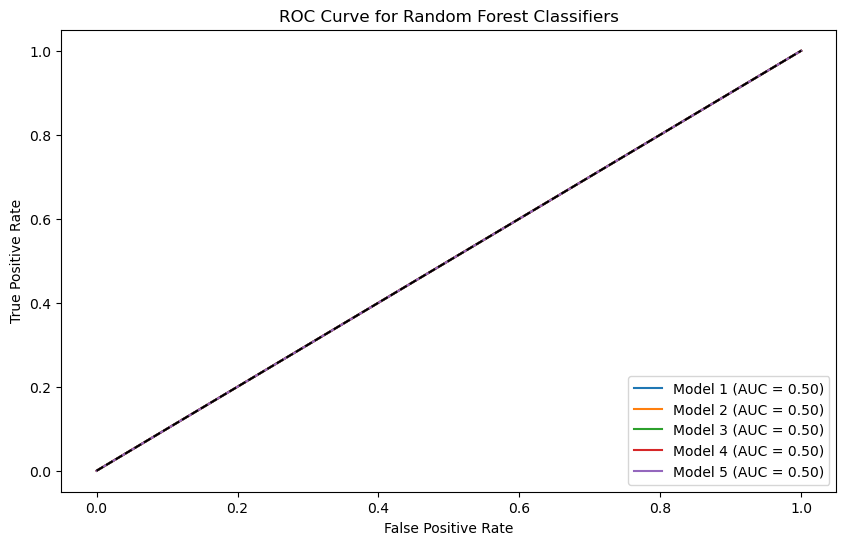

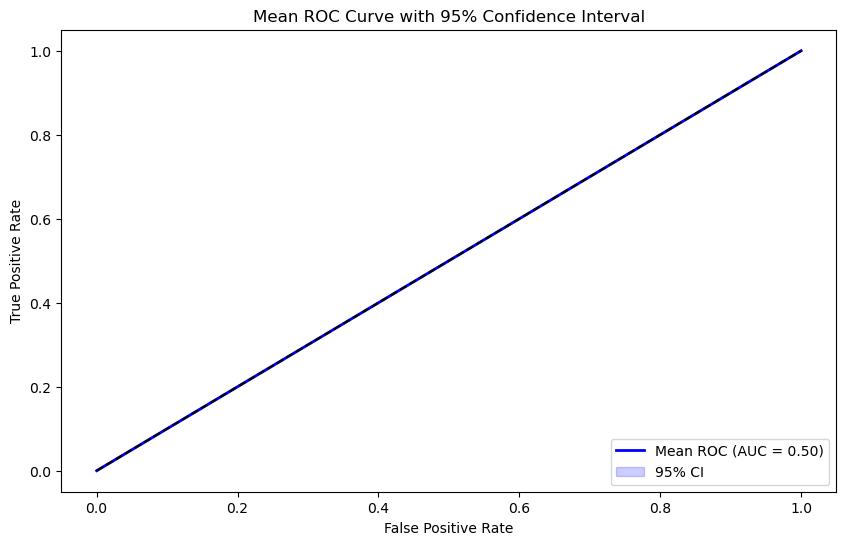

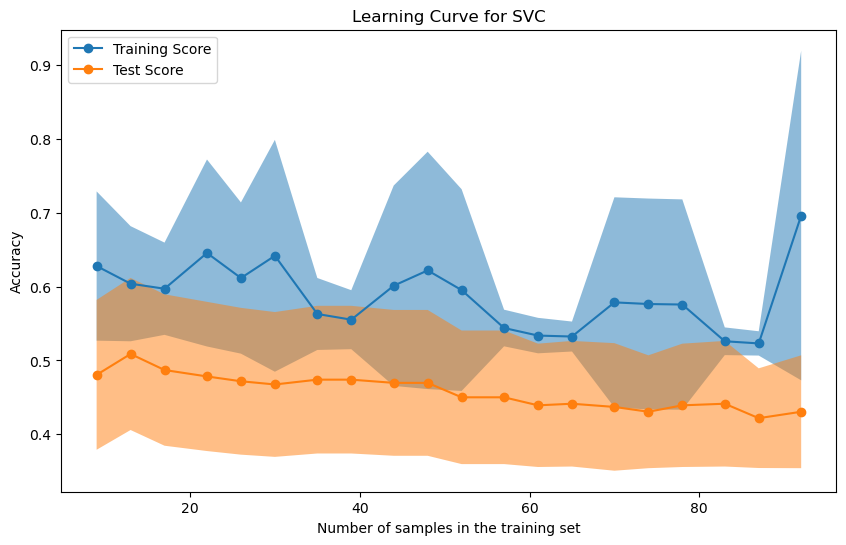

In [ ]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
def svm_classifier(data, selection):
    param_dist = {'gamma': np.logspace(-7, 1, 13), 'C' : np.logspace(-1, 6, 13)}

    rand_search_SVC = GridSearchCV(SVC(kernel='rbf', random_state=42, probability=True), 
                                    param_grid = param_dist, 
                                    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42))
    
    n = 5
    accuracy = []
    specificity = []
    sensitivity = []
    all_roc = np.linspace(0, 1, 100)
    roc_list = []
    best_rf_complete = []
    best_hyper_params = []
    features = []
    plt.figure(figsize=(10, 6))
    for i in range(1,n+1):
        if selection == 'forward filtering':
            split_lipoma = split_data(data_lipoma, n, i)
            split_liposarcoma = split_data(data_liposarcoma, n, i)
            features_train, features_test, label_train, label_test = [
                pd.concat([x, y]) for x, y in zip(split_lipoma, split_liposarcoma)
                ]
            train_data_rf = pd.concat([features_train, label_train], axis=1)
            model_select = SVC(kernel='rbf', random_state=42)
            accuracies, specificies, sensitivities, added_scores = forward_filtering(train_data_rf, model_select)
            best_features = added_scores.index(max(added_scores))+1
            features.append(best_features)
            p_values = calculate_p_values(train_data_rf)
            p_values_used = p_values[:best_features].index
            columns_to_keep = list(p_values_used)
            features_train = features_train[columns_to_keep]
            features_test = features_test[columns_to_keep]
        elif selection == 'pca':
            model_test = SVC(kernel='rbf', random_state=42)
            add_scores, accuracy, sensitivity, specificity = pca_feature_selection(data, model_test)
            best_pca = add_scores.index(max(add_scores))+1
            features.append(best_pca)
            pca = PCA(n_components=best_pca)
            pca_transform = pca.fit_transform(data.drop(columns='label'))
            data_pca = pd.DataFrame(data=pca_transform, columns=[f'PC{i+1}' for i in range(pca_transform.shape[1])])
            data_pca['label'] = data['label'].values

            data_lipoma_pca = data_pca[data_pca['label'] == 'lipoma']
            data_liposarcoma_pca = data_pca[data_pca['label'] == 'liposarcoma']

            split_lipoma_pca = split_data(data_lipoma_pca, n, i)
            split_liposarcoma_pca = split_data(data_liposarcoma_pca, n, i)
            features_train, features_test, label_train, label_test = [
            pd.concat([x, y]) for x, y in zip(split_lipoma_pca, split_liposarcoma_pca)
            ]
        rand_search_SVC.fit(features_train, label_train)
        best_rf = rand_search_SVC.best_estimator_
        print('Best hyperparameters:',  rand_search_SVC.best_params_)
        best_rf_complete.append(best_rf)
        best_hyper_params.append(rand_search_SVC.best_params_)
        label_pred = best_rf.predict(features_test)
        label_prob = best_rf.predict_proba(features_test)[:, 1]

        accuracy.append(accuracy_score(label_test, label_pred))
        specificity.append(recall_score(label_test, label_pred, pos_label='lipoma'))
        sensitivity.append(recall_score(label_test, label_pred, pos_label='liposarcoma'))
        print(f'Accuracy: {accuracy[i-1]}, Specificity: {specificity[i-1]}, Sensitivity: {sensitivity[i-1]}')

        fpr, tpr, _ = roc_curve(label_test, label_prob, pos_label='liposarcoma')
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, label=f'Model {i} (AUC = {roc_auc:.2f})')

        interp_roc = interp1d(fpr, tpr, kind='linear', bounds_error=False, fill_value=0)(all_roc)
        interp_roc[0] = 0
        roc_list.append(interp_roc)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for SVM(kernel=rbf)')
    plt.legend(loc='lower right')

    roc_array = np.array(roc_list)
    mean_roc = np.mean(roc_array, axis=0)
    std_roc = np.std(roc_array, axis=0)
    ci_upper = np.minimum(mean_roc + 1.96 * std_roc, 1)
    ci_lower = np.maximum(mean_roc - 1.96 * std_roc, 0)
    mean_auc = auc(all_roc, mean_roc)

    plt.figure(figsize=(10, 6))
    plt.plot(all_roc, mean_roc, color='blue', label=f'Mean ROC (AUC = {mean_auc:.2f})', linewidth=2)
    plt.fill_between(all_roc, ci_lower, ci_upper, color='blue', alpha=0.2, label='95% CI')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Mean ROC Curve with 95% Confidence Interval')
    plt.legend(loc='lower right')
    return best_rf_complete, best_hyper_params, features

best_rf_complete, best_hyper_params, feature_amount = svm_classifier(data, 'forward filtering')

p_values = calculate_p_values(data)
p_values_used = p_values[:feature_amount[0]].index
columns_to_keep = list(p_values_used) + ['label']
data_used = data[columns_to_keep]
learning_curve_plot(SVC, best_hyper_params[0], data_used)

best_rf_complete, best_hyper_params, pca_comp = svm_classifier(data, 'pca')

pca = PCA(n_components=pca_comp[0])
pca_transform = pca.fit_transform(data.drop(columns='label'))
data_pca = pd.DataFrame(data=pca_transform, columns=[f'PC{i+1}' for i in range(pca_transform.shape[1])])
data_pca['label'] = data['label'].values
learning_curve_plot(SVC, best_hyper_params[0], data_pca)